In [45]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load and Explore Data

In [46]:
# Load heliocentricity scores
helio_df = pd.read_csv('dataset/helio/heliocentricity_scores.csv')

# Load player names from input files
print("Loading player names from input files...")
train_path = Path('dataset/train')
input_files = sorted(train_path.glob('input*.csv'))

# Read just the unique player mappings from all weeks
player_dfs = []
for file in input_files:
    df = pd.read_csv(file, usecols=['nfl_id', 'player_name'])
    player_dfs.append(df)

players_df = pd.concat(player_dfs, ignore_index=True).drop_duplicates(subset=['nfl_id'])
players_df.columns = ['star_player_id', 'player_name']

print(f"Loaded {len(players_df)} unique player names")

# Merge player names with heliocentricity scores
helio_df = helio_df.merge(players_df, on='star_player_id', how='left')

print(f"\nLoaded {len(helio_df):,} plays with heliocentricity scores")
print(f"Unique players: {helio_df['star_player_id'].nunique()}")
print(f"Players with names: {helio_df['player_name'].notna().sum()} ({helio_df['player_name'].notna().sum() / len(helio_df) * 100:.1f}%)")
print(f"\nHeliocentricity Score Statistics:")
print(helio_df['H_score'].describe())

# Show sample data
print("\nSample data:")
helio_df[['game_id', 'play_id', 'star_player_id', 'player_name', 'H_score']].head(10)

Loading player names from input files...
Loaded 1384 unique player names

Loaded 2,822 plays with heliocentricity scores
Unique players: 450
Players with names: 2821 (100.0%)

Heliocentricity Score Statistics:
count    2822.000000
mean        0.296959
std         2.602600
min       -10.979200
25%        -1.229730
50%         0.402209
75%         1.862043
max        10.430747
Name: H_score, dtype: float64

Sample data:
Loaded 1384 unique player names

Loaded 2,822 plays with heliocentricity scores
Unique players: 450
Players with names: 2821 (100.0%)

Heliocentricity Score Statistics:
count    2822.000000
mean        0.296959
std         2.602600
min       -10.979200
25%        -1.229730
50%         0.402209
75%         1.862043
max        10.430747
Name: H_score, dtype: float64

Sample data:


,game_id,play_id,star_player_id,player_name,H_score
0,2023113000,286,44818.0,Jamal Adams,-0.325643
1,2023110504,3173,46087.0,Jaire Alexander,-3.575829
2,2023102910,4221,47808.0,Marquise Brown,5.963749
3,2023112302,696,46757.0,Charvarius Ward,-0.782431
4,2023122407,2867,47847.0,DK Metcalf,-2.471242
5,2024010713,1864,46142.0,Jerome Baker,-2.126270
6,2023121004,3597,46269.0,Foye Oluokun,0.410155
7,2023102203,1743,46111.0,Mike Gesicki,1.212204
8,2023120310,1477,54486.0,Trent McDuffie,-1.005153
9,2023092403,1749,45244.0,Taysom Hill,-0.620835


In [47]:
# Check for any missing values or data quality issues
print("Missing values:")
print(helio_df.isnull().sum())

print("\nData types:")
print(helio_df.dtypes)

# Distribution of H_scores
print(f"\nH_score range: [{helio_df['H_score'].min():.2f}, {helio_df['H_score'].max():.2f}]")
print(f"Negative scores (defense closer than expected): {(helio_df['H_score'] < 0).sum()} ({(helio_df['H_score'] < 0).sum() / len(helio_df) * 100:.1f}%)")
print(f"Positive scores (defense farther than expected): {(helio_df['H_score'] > 0).sum()} ({(helio_df['H_score'] > 0).sum() / len(helio_df) * 100:.1f}%)")

Missing values:
game_id           0
play_id           0
H_score           0
star_player_id    1
player_name       1
dtype: int64

Data types:
game_id             int64
play_id             int64
H_score           float64
star_player_id    float64
player_name        object
dtype: object

H_score range: [-10.98, 10.43]
Negative scores (defense closer than expected): 1217 (43.1%)
Positive scores (defense farther than expected): 1605 (56.9%)


## 2. Player-Level Aggregation

In [48]:
# Aggregate heliocentricity by player
player_stats = helio_df.groupby('star_player_id').agg({
    'H_score': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'game_id': 'nunique',
    'play_id': 'count',
    'player_name': 'first'  # Get player name
}).round(3)

# Flatten column names
player_stats.columns = ['_'.join(col).strip() for col in player_stats.columns.values]
player_stats.rename(columns={
    'H_score_mean': 'avg_H_score',
    'H_score_median': 'median_H_score',
    'H_score_std': 'std_H_score',
    'H_score_min': 'min_H_score',
    'H_score_max': 'max_H_score',
    'H_score_count': 'total_plays',
    'game_id_nunique': 'games_played',
    'player_name_first': 'player_name'
}, inplace=True)

# Calculate coefficient of variation (consistency metric)
player_stats['cv'] = (player_stats['std_H_score'] / player_stats['avg_H_score'].abs()).replace([np.inf, -np.inf], np.nan)

# Reset index
player_stats = player_stats.reset_index()

print(f"Player-level statistics calculated for {len(player_stats)} players")
print(f"\nPlayers with at least 10 plays: {(player_stats['total_plays'] >= 10).sum()}")
player_stats.head(10)

Player-level statistics calculated for 450 players

Players with at least 10 plays: 102


,star_player_id,avg_H_score,median_H_score,std_H_score,min_H_score,max_H_score,total_plays,games_played,play_id_count,player_name,cv
0,42467.0,0.472,0.472,2.867,-1.556,2.499,2,1,2,Kwon Alexander,6.074153
1,42485.0,-3.898,-3.898,5.101,-7.505,-0.291,2,1,2,Adrian Amos,1.308620
2,42486.0,-2.773,-2.773,NaN,-2.773,-2.773,1,1,1,MyCole Pruitt,NaN
3,42794.0,1.960,1.960,0.137,1.864,2.057,2,2,2,DeAndre Carter,0.069898
4,43306.0,1.097,1.097,NaN,1.097,1.097,1,1,1,Keanu Neal,NaN
5,43314.0,1.585,1.634,1.198,-0.036,3.643,7,2,7,Artie Burns,0.755836
6,43324.0,-0.869,-0.869,NaN,-0.869,-0.869,1,1,1,Hunter Henry,NaN
7,43325.0,-0.796,-0.898,1.128,-1.949,0.698,5,2,5,Myles Jack,1.417085
8,43327.0,2.398,2.279,2.534,-0.074,4.990,3,2,3,Xavien Howard,1.056714
9,43329.0,1.937,1.937,NaN,1.937,1.937,1,1,1,Sterling Shepard,NaN


## 3. Top Players by Heliocentricity

In [49]:
# Filter for players with meaningful sample size (at least 10 plays)
qualified_players = player_stats[player_stats['total_plays'] >= 10].copy()

print(f"Analyzing {len(qualified_players)} players with 10+ plays\n")

# Top 15 players by average heliocentricity (most defensive attention)
print("=" * 80)
print("TOP 15 PLAYERS - HIGHEST HELIOCENTRICITY (Defense Gave Most Space)")
print("=" * 80)
top_players = qualified_players.nlargest(15, 'avg_H_score')[[
    'player_name', 'star_player_id', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games_played'
]]
print(top_players.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 15 PLAYERS - LOWEST HELIOCENTRICITY (Defense Played Tight Coverage)")
print("=" * 80)
bottom_players = qualified_players.nsmallest(15, 'avg_H_score')[[
    'player_name', 'star_player_id', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games_played'
]]
print(bottom_players.to_string(index=False))

Analyzing 102 players with 10+ plays

TOP 15 PLAYERS - HIGHEST HELIOCENTRICITY (Defense Gave Most Space)
     player_name  star_player_id  avg_H_score  median_H_score  std_H_score  total_plays  games_played
    A.J. Terrell         52424.0        3.009           1.285        3.410           10             7
      Jamel Dean         47877.0        2.942           2.400        2.943           10             6
    J.C. Jackson         46775.0        2.789           1.667        3.106           12             8
  Amik Robertson         52547.0        2.766           2.412        3.151           10             5
  Marquise Brown         47808.0        2.580           2.146        2.364           17             7
    Isaac Yiadom         46168.0        2.529           3.108        2.773           12             4
   Donte Jackson         46124.0        2.472           2.505        2.345           18             9
   Michael Davis         45571.0        2.466           2.273        3.035     

In [50]:
# Most consistent players (low coefficient of variation)
print("=" * 80)
print("MOST CONSISTENT PLAYERS (Low Variability in Heliocentricity)")
print("=" * 80)
consistent_players = qualified_players.nsmallest(15, 'cv')[[
    'player_name', 'star_player_id', 'avg_H_score', 'std_H_score', 'cv', 'total_plays'
]]
print(consistent_players.to_string(index=False))

print("\n" + "=" * 80)
print("MOST VARIABLE PLAYERS (High Variability in Heliocentricity)")
print("=" * 80)
variable_players = qualified_players.nlargest(15, 'cv')[[
    'player_name', 'star_player_id', 'avg_H_score', 'std_H_score', 'cv', 'total_plays'
]]
print(variable_players.to_string(index=False))

MOST CONSISTENT PLAYERS (Low Variability in Heliocentricity)
       player_name  star_player_id  avg_H_score  std_H_score       cv  total_plays
         AJ Dillon         52470.0        1.980        0.738 0.372727           10
   Robert Spillane         46902.0       -2.518        1.836 0.729150           11
      Mike Edwards         47882.0       -1.821        1.442 0.791873           12
Alexander Mattison         47885.0        1.185        0.953 0.804219           12
      Tony Pollard         47911.0        1.861        1.542 0.828587           11
       Marcus Epps         47974.0       -1.715        1.543 0.899708           23
    Marquise Brown         47808.0        2.580        2.364 0.916279           17
    KhaDarel Hodge         46992.0        2.145        1.986 0.925874           12
    Darnell Savage         47804.0       -2.286        2.163 0.946194           12
     Donte Jackson         46124.0        2.472        2.345 0.948625           18
        Jamel Dean        

## 4. Extreme Plays Analysis

In [51]:
# Top individual plays by heliocentricity
print("=" * 80)
print("TOP 20 PLAYS - HIGHEST HELIOCENTRICITY")
print("=" * 80)
top_plays = helio_df.nlargest(20, 'H_score')[['player_name', 'game_id', 'play_id', 'star_player_id', 'H_score']]
print(top_plays.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 20 PLAYS - LOWEST HELIOCENTRICITY (Tightest Coverage)")
print("=" * 80)
bottom_plays = helio_df.nsmallest(20, 'H_score')[['player_name', 'game_id', 'play_id', 'star_player_id', 'H_score']]
print(bottom_plays.to_string(index=False))

TOP 20 PLAYS - HIGHEST HELIOCENTRICITY
     player_name    game_id  play_id  star_player_id   H_score
      Jamel Dean 2023123109      184         47877.0 10.430747
   Adam Trautman 2023100809     1584         52513.0  9.722605
    J.C. Jackson 2023110506     2061         46775.0  9.691134
 Michael Pittman 2023091003     2062         52442.0  9.571641
    Levi Wallace 2023111205     4302         46698.0  9.233776
Darious Williams 2023121004     4298         46456.0  8.747909
Shaquill Griffin 2023091001     4018         44902.0  8.733563
 Joshua Williams 2024010709     3598         54600.0  8.628326
  Terry McLaurin 2023122406       79         47859.0  8.455653
  Brandon Powell 2023111911     2227         46830.0  8.302625
Darious Williams 2023101900     1277         46456.0  8.019443
    A.J. Terrell 2023121709     1440         52424.0  8.010278
    A.J. Terrell 2023122402     4230         52424.0  7.954511
  Amik Robertson 2023100900     3776         52547.0  7.816631
     Jeff Okudah

## 5. Visualizations

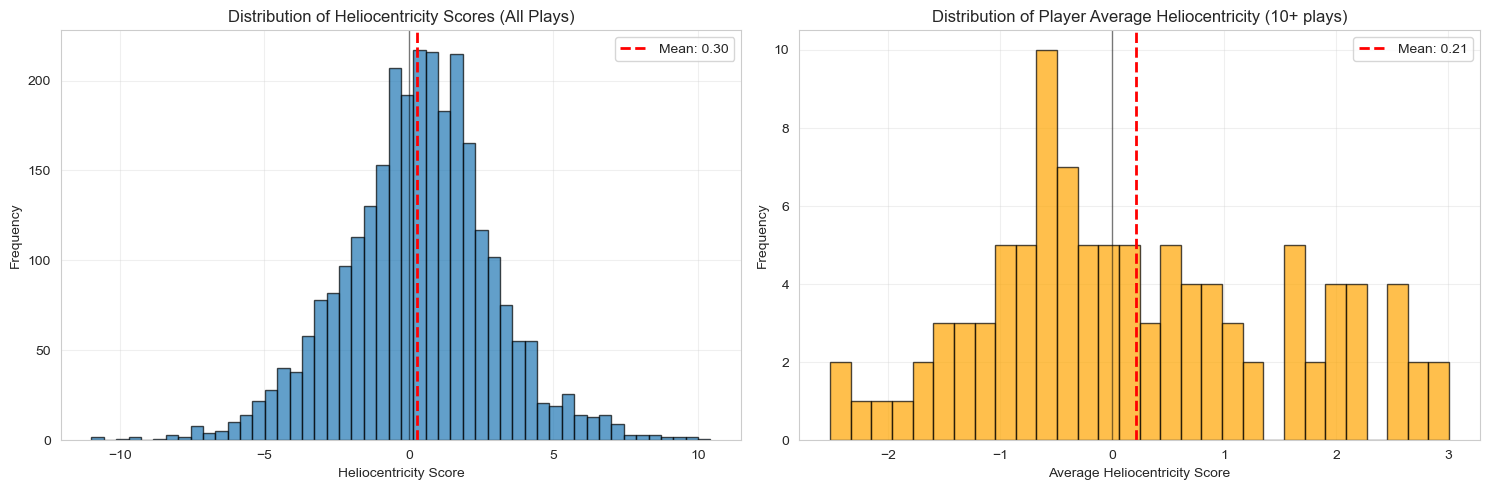

In [52]:
# Distribution of heliocentricity scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(helio_df['H_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(helio_df['H_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {helio_df['H_score'].mean():.2f}")
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Heliocentricity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Heliocentricity Scores (All Plays)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Player average distribution
axes[1].hist(qualified_players['avg_H_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(qualified_players['avg_H_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {qualified_players['avg_H_score'].mean():.2f}")
axes[1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Average Heliocentricity Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Player Average Heliocentricity (10+ plays)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

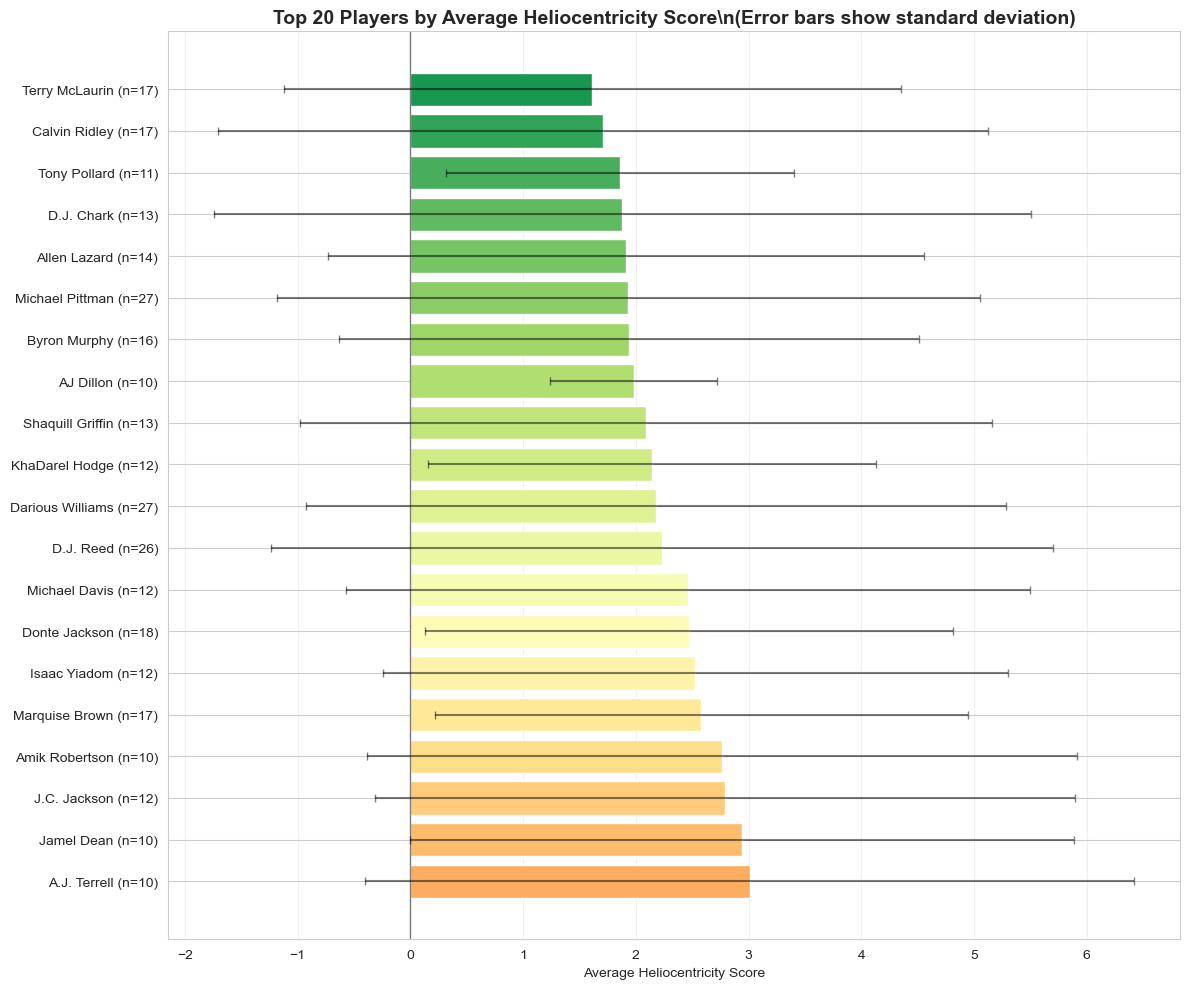

In [53]:
# Top 20 players visualization
top_20 = qualified_players.nlargest(20, 'avg_H_score')

fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(top_20)), top_20['avg_H_score'], 
               color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_20))))

# Add error bars for standard deviation
ax.errorbar(top_20['avg_H_score'], range(len(top_20)), 
            xerr=top_20['std_H_score'], fmt='none', ecolor='black', alpha=0.5, capsize=3)

ax.set_yticks(range(len(top_20)))
ax.set_yticklabels([f"{name} (n={n})" for name, n in zip(top_20['player_name'], top_20['total_plays'])])
ax.set_xlabel('Average Heliocentricity Score')
ax.set_title('Top 20 Players by Average Heliocentricity Score\\n(Error bars show standard deviation)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

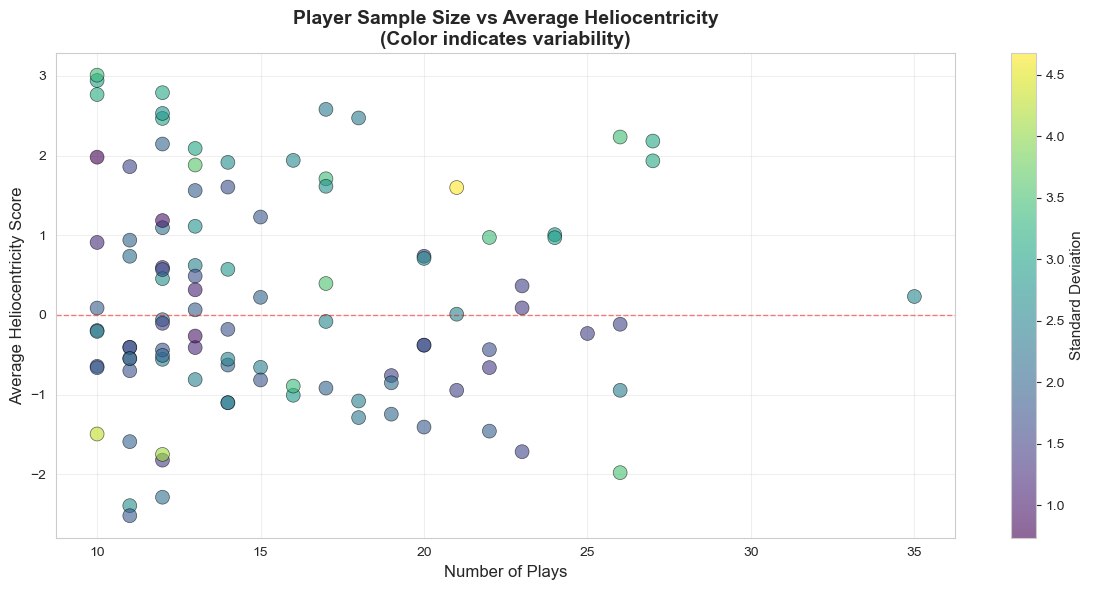

In [54]:
# Scatter: Sample size vs Average Heliocentricity
fig, ax = plt.subplots(figsize=(12, 6))

scatter = ax.scatter(qualified_players['total_plays'], 
                     qualified_players['avg_H_score'],
                     c=qualified_players['std_H_score'],
                     s=100, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)

ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Number of Plays', fontsize=12)
ax.set_ylabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Player Sample Size vs Average Heliocentricity\n(Color indicates variability)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Standard Deviation', fontsize=11)

plt.tight_layout()
plt.show()

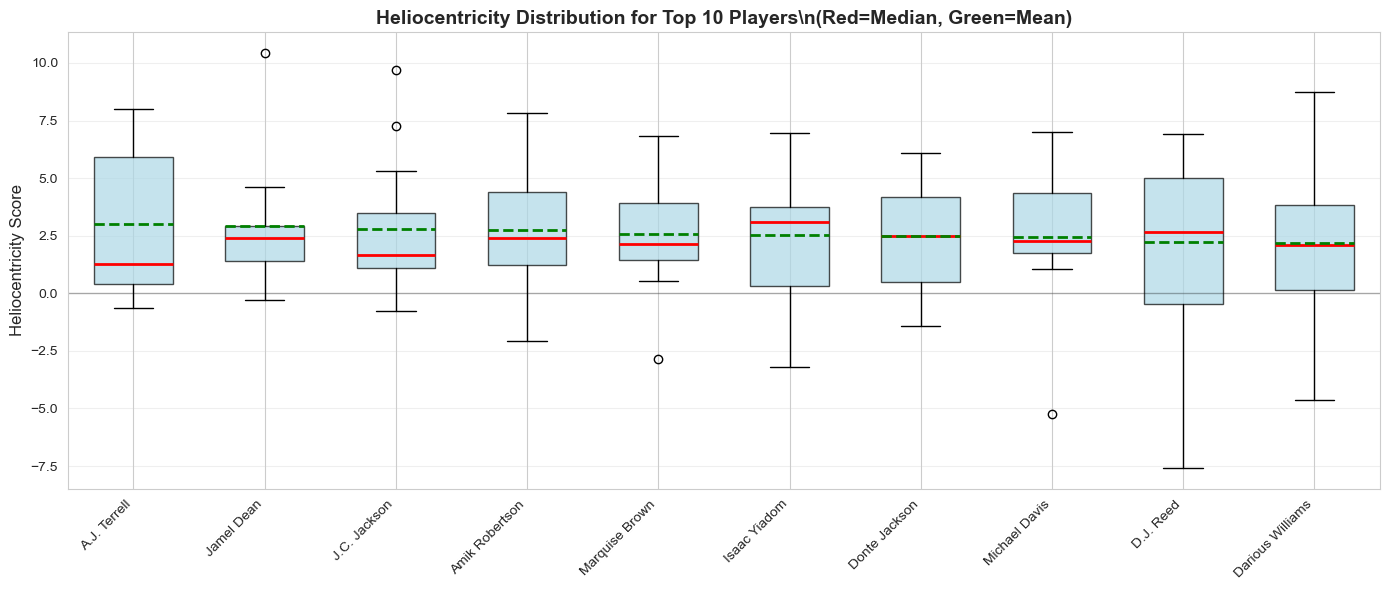

In [55]:
# Box plot: Distribution comparison for top 10 players
top_10 = qualified_players.nlargest(10, 'avg_H_score')
top_10_ids = top_10['star_player_id'].values
top_10_names = top_10['player_name'].values
top_10_data = helio_df[helio_df['star_player_id'].isin(top_10_ids)]

fig, ax = plt.subplots(figsize=(14, 6))

# Create box plot
positions = range(len(top_10_ids))
box_data = [top_10_data[top_10_data['star_player_id'] == pid]['H_score'].values for pid in top_10_ids]

bp = ax.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                showmeans=True, meanline=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(color='green', linewidth=2, linestyle='--'))

ax.set_xticks(positions)
ax.set_xticklabels(top_10_names, rotation=45, ha='right')
ax.set_ylabel('Heliocentricity Score', fontsize=12)
ax.set_title('Heliocentricity Distribution for Top 10 Players\\n(Red=Median, Green=Mean)', fontsize=14, fontweight='bold')
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Summary Statistics and Insights

In [56]:
print("=" * 80)
print("OVERALL SUMMARY")
print("=" * 80)
print(f"Total plays analyzed: {len(helio_df):,}")
print(f"Unique players: {helio_df['star_player_id'].nunique()}")
print(f"Players with 10+ plays: {len(qualified_players)}")
print(f"\nOverall Heliocentricity Statistics:")
print(f"  Mean: {helio_df['H_score'].mean():.3f}")
print(f"  Median: {helio_df['H_score'].median():.3f}")
print(f"  Std Dev: {helio_df['H_score'].std():.3f}")
print(f"  Min: {helio_df['H_score'].min():.3f}")
print(f"  Max: {helio_df['H_score'].max():.3f}")
print(f"\nInterpretation:")
print(f"  - Positive H-score: Defense gave MORE space than expected (commanded attention)")
print(f"  - Negative H-score: Defense played TIGHTER coverage than expected")
print(f"  - Zero: Defense coverage matched expectations")

# Percentile breakdown
print(f"\nPercentile Breakdown:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {np.percentile(helio_df['H_score'], p):.3f}")

OVERALL SUMMARY
Total plays analyzed: 2,822
Unique players: 450
Players with 10+ plays: 102

Overall Heliocentricity Statistics:
  Mean: 0.297
  Median: 0.402
  Std Dev: 2.603
  Min: -10.979
  Max: 10.431

Interpretation:
  - Positive H-score: Defense gave MORE space than expected (commanded attention)
  - Negative H-score: Defense played TIGHTER coverage than expected
  - Zero: Defense coverage matched expectations

Percentile Breakdown:
  10th percentile: -3.006
  25th percentile: -1.230
  50th percentile: 0.402
  75th percentile: 1.862
  90th percentile: 3.310
  95th percentile: 4.355
  99th percentile: 6.907


In [57]:
# Save processed player statistics
output_path = 'dataset/helio/player_heliocentricity_stats.csv'
qualified_players.to_csv(output_path, index=False)
print(f"✓ Saved player statistics to {output_path}")

# Save top/bottom players
top_players_output = 'dataset/helio/top_players_heliocentricity.csv'
qualified_players.nlargest(50, 'avg_H_score').to_csv(top_players_output, index=False)
print(f"✓ Saved top 50 players to {top_players_output}")

✓ Saved player statistics to dataset/helio/player_heliocentricity_stats.csv
✓ Saved top 50 players to dataset/helio/top_players_heliocentricity.csv


## 7. Wide Receiver Analysis

Focus on pass catchers (WR, TE) to identify elite players who commanded the most defensive attention.

In [58]:
# Load player positions from input files
print("Loading player positions...")

# Read positions from all weeks
position_dfs = []
for file in input_files:
    df = pd.read_csv(file, usecols=['nfl_id', 'player_position'])
    position_dfs.append(df)

positions_df = pd.concat(position_dfs, ignore_index=True).drop_duplicates(subset=['nfl_id'])
positions_df.columns = ['star_player_id', 'player_position']

# Merge positions with player stats
player_stats_with_pos = player_stats.merge(positions_df, on='star_player_id', how='left')

print(f"Loaded positions for {positions_df['star_player_id'].nunique()} players")
print(f"\nPosition distribution in dataset:")
print(player_stats_with_pos['player_position'].value_counts())

# Filter for pass catchers (WR and TE)
wr_stats = player_stats_with_pos[player_stats_with_pos['player_position'] == 'WR'].copy()
te_stats = player_stats_with_pos[player_stats_with_pos['player_position'] == 'TE'].copy()
pass_catcher_stats = player_stats_with_pos[player_stats_with_pos['player_position'].isin(['WR', 'TE'])].copy()

print(f"\nWide Receivers: {len(wr_stats)} players")
print(f"Tight Ends: {len(te_stats)} players")
print(f"Total Pass Catchers: {len(pass_catcher_stats)} players")

Loading player positions...
Loaded positions for 1384 players

Position distribution in dataset:
player_position
WR     91
CB     70
TE     49
FS     45
ILB    37
RB     36
QB     32
OLB    29
SS     27
MLB    18
FB      7
DT      5
DE      3
S       1
Name: count, dtype: int64

Wide Receivers: 91 players
Tight Ends: 49 players
Total Pass Catchers: 140 players
Loaded positions for 1384 players

Position distribution in dataset:
player_position
WR     91
CB     70
TE     49
FS     45
ILB    37
RB     36
QB     32
OLB    29
SS     27
MLB    18
FB      7
DT      5
DE      3
S       1
Name: count, dtype: int64

Wide Receivers: 91 players
Tight Ends: 49 players
Total Pass Catchers: 140 players


### 7.1 Position Distribution Analysis

**Important Note:** Heliocentricity is designed to measure how much defensive attention an **offensive player** draws. Defensive players in the dataset indicate a conceptual issue - the metric doesn't make sense for defenders since they ARE the defense, not the target of defensive coverage.

In [59]:
# Analyze offensive vs defensive players in the dataset
print("=" * 80)
print("POSITION ANALYSIS: OFFENSIVE vs DEFENSIVE PLAYERS")
print("=" * 80)

# Define offensive and defensive positions
offensive_positions = ['WR', 'TE', 'RB', 'QB', 'FB']
defensive_positions = ['CB', 'FS', 'SS', 'S', 'ILB', 'OLB', 'MLB', 'DT', 'DE', 'LB']

player_stats_with_pos['side'] = player_stats_with_pos['player_position'].apply(
    lambda x: 'Offense' if x in offensive_positions else ('Defense' if x in defensive_positions else 'Unknown')
)

print("\nPlayer distribution by side:")
print(player_stats_with_pos['side'].value_counts())

offense_players = player_stats_with_pos[player_stats_with_pos['side'] == 'Offense']
defense_players = player_stats_with_pos[player_stats_with_pos['side'] == 'Defense']

print(f"\nOffensive players: {len(offense_players)} ({len(offense_players)/len(player_stats_with_pos)*100:.1f}%)")
print(f"Defensive players: {len(defense_players)} ({len(defense_players)/len(player_stats_with_pos)*100:.1f}%)")

print("\n" + "=" * 80)
print("WHY DEFENSIVE PLAYERS DON'T MAKE SENSE FOR HELIOCENTRICITY:")
print("=" * 80)
print("• Heliocentricity measures: 'How much defensive attention does this player draw?'")
print("• For offensive receivers: High H = Defense gave them MORE space than expected")
print("• For defensive players: Measuring distance from defender to OTHER defenders")
print("  → This doesn't measure 'attention' - it's just defender spacing")
print("  → A CB with high H means other defenders stayed far from the CB (not meaningful)")
print("\n✓ RECOMMENDATION: Filter to offensive pass catchers only (WR, TE, RB)")

# Show top defensive players (to illustrate the problem)
print("\n" + "=" * 80)
print("TOP 10 DEFENSIVE PLAYERS (This shouldn't be meaningful)")
print("=" * 80)
top_def = defense_players.nlargest(10, 'avg_H_score')[['player_name', 'player_position', 'avg_H_score', 'total_plays']]
print(top_def.to_string(index=False))

POSITION ANALYSIS: OFFENSIVE vs DEFENSIVE PLAYERS

Player distribution by side:
side
Defense    235
Offense    215
Name: count, dtype: int64

Offensive players: 215 (47.8%)
Defensive players: 235 (52.2%)

WHY DEFENSIVE PLAYERS DON'T MAKE SENSE FOR HELIOCENTRICITY:
• Heliocentricity measures: 'How much defensive attention does this player draw?'
• For offensive receivers: High H = Defense gave them MORE space than expected
• For defensive players: Measuring distance from defender to OTHER defenders
  → This doesn't measure 'attention' - it's just defender spacing
  → A CB with high H means other defenders stayed far from the CB (not meaningful)

✓ RECOMMENDATION: Filter to offensive pass catchers only (WR, TE, RB)

TOP 10 DEFENSIVE PLAYERS (This shouldn't be meaningful)
      player_name player_position  avg_H_score  total_plays
     Dane Jackson              CB        7.241            1
 Brandon Stephens              CB        6.970            1
  Joshua Williams              CB       

### 7.2 Offensive Players Only - Corrected Analysis

In [60]:
# Filter for OFFENSIVE PLAYERS ONLY
offensive_stats = player_stats_with_pos[player_stats_with_pos['side'] == 'Offense'].copy()
offensive_qualified = offensive_stats[offensive_stats['total_plays'] >= 10].copy()

print(f"Analyzing {len(offensive_qualified)} offensive players with 10+ plays\n")

# Top offensive players by heliocentricity
print("=" * 80)
print("TOP 20 OFFENSIVE PLAYERS - HIGHEST HELIOCENTRICITY")
print("(These players drew the most defensive attention)")
print("=" * 80)
top_offensive = offensive_qualified.nlargest(20, 'avg_H_score')[[
    'player_name', 'player_position', 'avg_H_score', 'median_H_score', 'total_plays'
]]
print(top_offensive.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 20 OFFENSIVE PLAYERS - LOWEST HELIOCENTRICITY")
print("(These players faced tightest coverage)")
print("=" * 80)
bottom_offensive = offensive_qualified.nsmallest(20, 'avg_H_score')[[
    'player_name', 'player_position', 'avg_H_score', 'median_H_score', 'total_plays'
]]
print(bottom_offensive.to_string(index=False))

# Breakdown by offensive position
print("\n" + "=" * 80)
print("AVERAGE HELIOCENTRICITY BY OFFENSIVE POSITION")
print("=" * 80)
for pos in offensive_positions:
    pos_players = offensive_stats[offensive_stats['player_position'] == pos]
    if len(pos_players) > 0:
        print(f"\n{pos}:")
        print(f"  Players: {len(pos_players)}")
        print(f"  Avg H-score: {pos_players['avg_H_score'].mean():.4f}")
        print(f"  Median H-score: {pos_players['avg_H_score'].median():.4f}")
        print(f"  Std Dev: {pos_players['avg_H_score'].std():.4f}")

Analyzing 42 offensive players with 10+ plays

TOP 20 OFFENSIVE PLAYERS - HIGHEST HELIOCENTRICITY
(These players drew the most defensive attention)
       player_name player_position  avg_H_score  median_H_score  total_plays
    Marquise Brown              WR        2.580           2.146           17
    KhaDarel Hodge              WR        2.145           2.104           12
         AJ Dillon              RB        1.980           1.814           10
   Michael Pittman              WR        1.934           1.677           27
      Allen Lazard              WR        1.915           1.198           14
        D.J. Chark              WR        1.882           2.600           13
      Tony Pollard              RB        1.861           1.839           11
     Calvin Ridley              WR        1.709           2.708           17
    Terry McLaurin              WR        1.615           1.243           17
    Gerald Everett              TE        1.605           1.288           14
     

/var/folders/py/cfchh_0s3zv0_x826rm19h1r0000gn/T/ipykernel_26844/2831498088.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([off_data, def_data], labels=['Offensive Players', 'Defensive Players'],


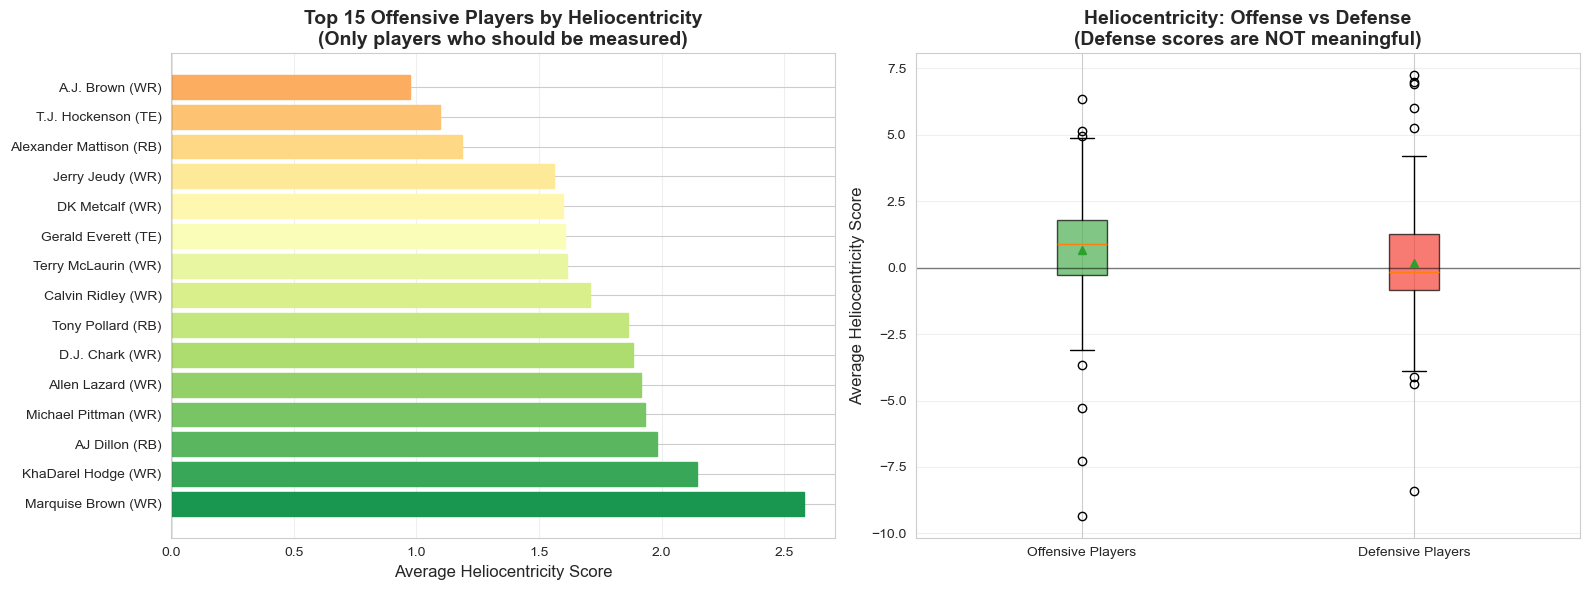


Interpretation:
• GREEN (Offense): These scores are meaningful - measuring defensive attention
• RED (Defense): These scores are NOT meaningful - artifacts of the calculation


In [61]:
# Visualization: Offensive players only
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 offensive players
top_15_off = offensive_qualified.nlargest(15, 'avg_H_score')
bars = axes[0].barh(range(len(top_15_off)), top_15_off['avg_H_score'].values)
axes[0].set_yticks(range(len(top_15_off)))
axes[0].set_yticklabels([f"{name} ({pos})" for name, pos in zip(top_15_off['player_name'], top_15_off['player_position'])])
axes[0].set_xlabel('Average Heliocentricity Score', fontsize=12)
axes[0].set_title('Top 15 Offensive Players by Heliocentricity\n(Only players who should be measured)', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].grid(axis='x', alpha=0.3)

# Color bars
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

# Comparison: Offense vs Defense (to show the problem)
off_data = offensive_stats['avg_H_score'].values
def_data = defense_players['avg_H_score'].values

bp = axes[1].boxplot([off_data, def_data], labels=['Offensive Players', 'Defensive Players'],
                      patch_artist=True, showmeans=True)

bp['boxes'][0].set_facecolor('#4CAF50')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('#F44336')
bp['boxes'][1].set_alpha(0.7)

axes[1].set_ylabel('Average Heliocentricity Score', fontsize=12)
axes[1].set_title('Heliocentricity: Offense vs Defense\n(Defense scores are NOT meaningful)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• GREEN (Offense): These scores are meaningful - measuring defensive attention")
print("• RED (Defense): These scores are NOT meaningful - artifacts of the calculation")

In [62]:
# Save corrected offensive-only rankings
offensive_output = offensive_stats[['star_player_id', 'player_name', 'player_position', 
                                     'avg_H_score', 'median_H_score', 'std_H_score', 
                                     'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

offensive_output.to_csv('dataset/helio/offensive_players_heliocentricity.csv', index=False)
print(f"✓ Saved offensive players ranking to dataset/helio/offensive_players_heliocentricity.csv ({len(offensive_output)} players)")

# Also create a pass catchers only version (WR, TE, RB)
pass_catchers = offensive_stats[offensive_stats['player_position'].isin(['WR', 'TE', 'RB'])].copy()
pass_catchers_output = pass_catchers[['star_player_id', 'player_name', 'player_position', 
                                       'avg_H_score', 'median_H_score', 'std_H_score', 
                                       'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

pass_catchers_output.to_csv('dataset/helio/pass_catchers_heliocentricity.csv', index=False)
print(f"✓ Saved pass catchers ranking to dataset/helio/pass_catchers_heliocentricity.csv ({len(pass_catchers_output)} players)")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total players in original dataset: {len(player_stats_with_pos)}")
print(f"  → Offensive players: {len(offensive_stats)} ({len(offensive_stats)/len(player_stats_with_pos)*100:.1f}%)")
print(f"  → Defensive players: {len(defense_players)} ({len(defense_players)/len(player_stats_with_pos)*100:.1f}%) [NOT MEANINGFUL]")
print(f"\nPass catchers (WR/TE/RB): {len(pass_catchers)}")
print(f"  → These are the most relevant for heliocentricity analysis")
print("\n✓ Use offensive_players_heliocentricity.csv or pass_catchers_heliocentricity.csv for valid analysis")

✓ Saved offensive players ranking to dataset/helio/offensive_players_heliocentricity.csv (215 players)
✓ Saved pass catchers ranking to dataset/helio/pass_catchers_heliocentricity.csv (176 players)

SUMMARY
Total players in original dataset: 450
  → Offensive players: 215 (47.8%)
  → Defensive players: 235 (52.2%) [NOT MEANINGFUL]

Pass catchers (WR/TE/RB): 176
  → These are the most relevant for heliocentricity analysis

✓ Use offensive_players_heliocentricity.csv or pass_catchers_heliocentricity.csv for valid analysis


In [63]:
# Top Wide Receivers by Heliocentricity
print("=" * 80)
print("TOP 20 WIDE RECEIVERS BY AVERAGE HELIOCENTRICITY SCORE")
print("=" * 80)

top_wr = wr_stats.nlargest(20, 'avg_H_score')[['player_name', 'avg_H_score', 'median_H_score', 'total_plays', 'cv']]
print(top_wr.to_string(index=False))

print("\n" + "=" * 80)
print("TOP 20 TIGHT ENDS BY AVERAGE HELIOCENTRICITY SCORE")
print("=" * 80)

top_te = te_stats.nlargest(20, 'avg_H_score')[['player_name', 'avg_H_score', 'median_H_score', 'total_plays', 'cv']]
print(top_te.to_string(index=False))

print("\n" + "=" * 80)
print("MOST CONSISTENT WIDE RECEIVERS (Lowest Coefficient of Variation)")
print("=" * 80)

consistent_wr = wr_stats[wr_stats['total_plays'] >= 10].nsmallest(15, 'cv')[['player_name', 'avg_H_score', 'cv', 'total_plays']]
print(consistent_wr.to_string(index=False))

TOP 20 WIDE RECEIVERS BY AVERAGE HELIOCENTRICITY SCORE
          player_name  avg_H_score  median_H_score  total_plays       cv
       Michael Thomas        6.346           6.346            2 0.023322
         James Proche        5.127           5.127            1      NaN
       Chase Claypool        4.935           4.935            1      NaN
       George Pickens        4.867           4.867            1      NaN
Donovan Peoples-Jones        3.488           3.488            1      NaN
         Jalen Reagor        3.454           3.454            2 0.032716
           Gabe Davis        3.386           3.430            3 0.254873
          David Moore        3.370           3.370            1      NaN
         Mack Hollins        3.333           3.333            1      NaN
          CeeDee Lamb        3.280           2.742            8 0.762500
     Christian Watson        3.212           3.212            1      NaN
          Zach Pascal        2.948           2.948            1      

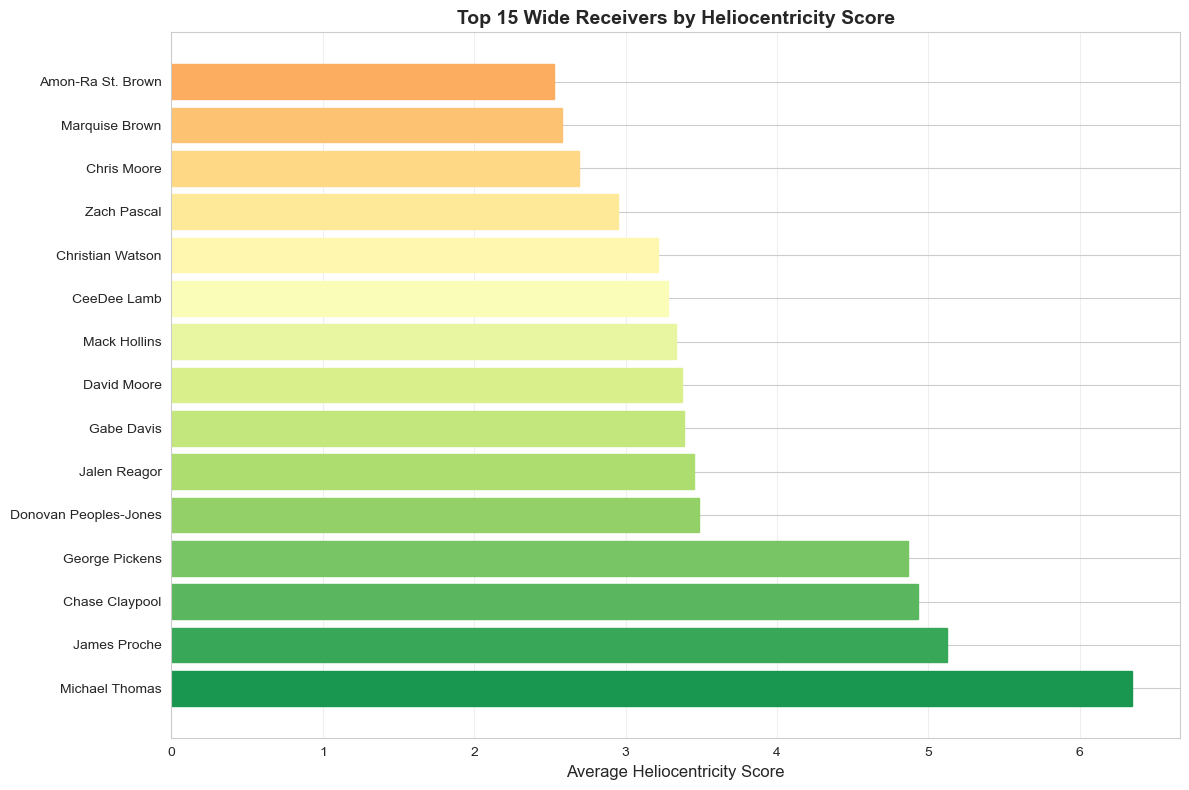

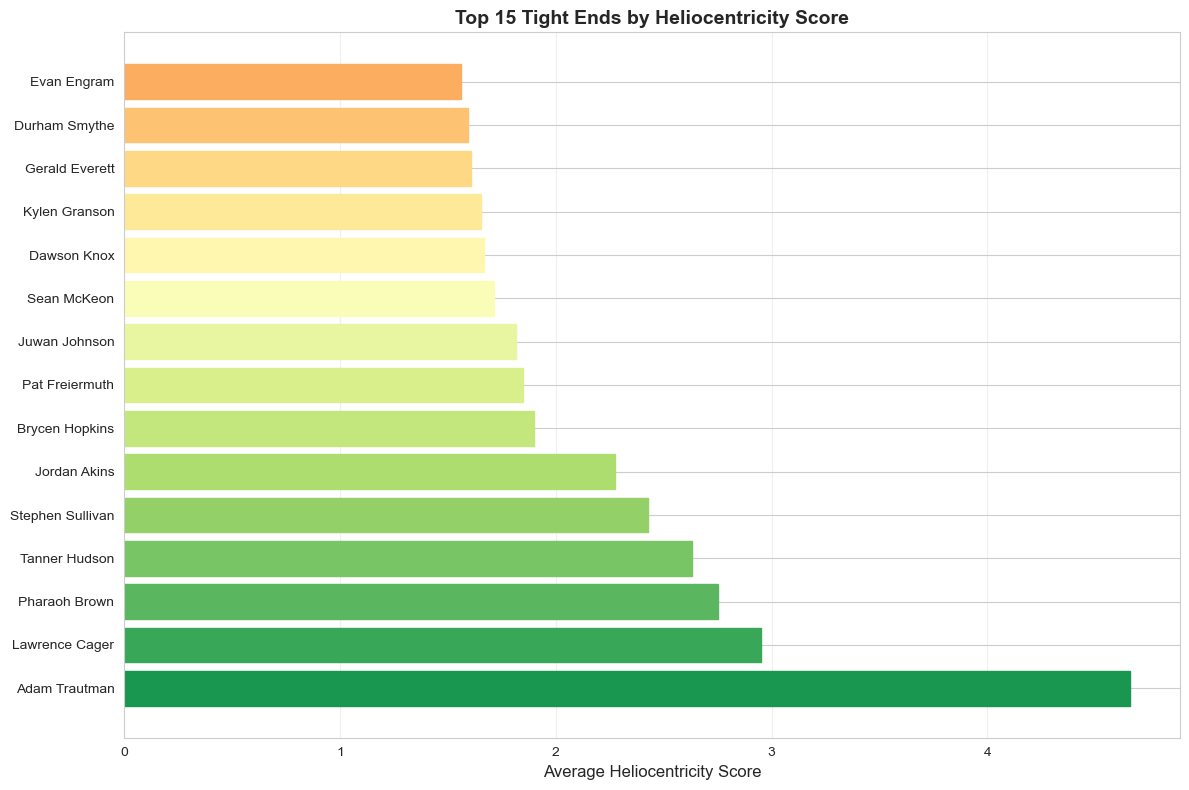

In [64]:
# Visualization: Top 15 WRs by Heliocentricity
fig, ax = plt.subplots(figsize=(12, 8))

top_15_wr = wr_stats.nlargest(15, 'avg_H_score')
bars = ax.barh(range(len(top_15_wr)), top_15_wr['avg_H_score'].values)
ax.set_yticks(range(len(top_15_wr)))
ax.set_yticklabels(top_15_wr['player_name'].values)
ax.set_xlabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Top 15 Wide Receivers by Heliocentricity Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Color bars by value
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

plt.tight_layout()
plt.show()

# Visualization: Top 15 TEs by Heliocentricity
fig, ax = plt.subplots(figsize=(12, 8))

top_15_te = te_stats.nlargest(15, 'avg_H_score')
bars = ax.barh(range(len(top_15_te)), top_15_te['avg_H_score'].values)
ax.set_yticks(range(len(top_15_te)))
ax.set_yticklabels(top_15_te['player_name'].values)
ax.set_xlabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Top 15 Tight Ends by Heliocentricity Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Color bars by value
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

plt.tight_layout()
plt.show()

/var/folders/py/cfchh_0s3zv0_x826rm19h1r0000gn/T/ipykernel_26844/1375377300.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(position_data, labels=['Wide Receivers', 'Tight Ends', 'Other Positions'],


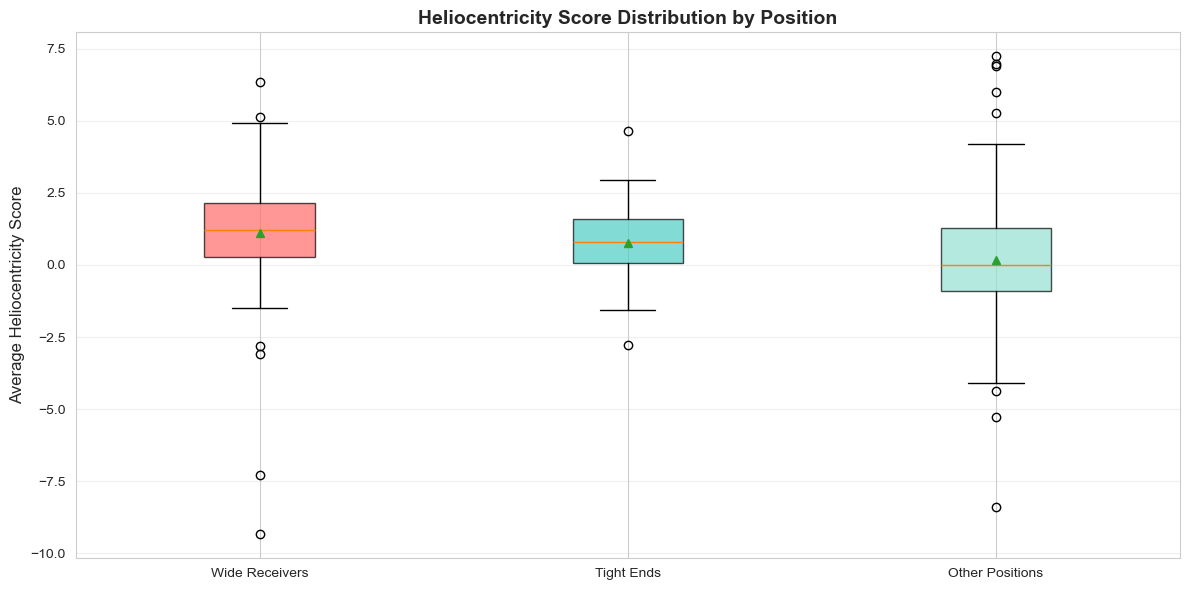


Summary Statistics by Position:

WR:
  Count: 91
  Mean: 1.1192
  Median: 1.2160
  Std: 2.1224

TE:
  Count: 49
  Mean: 0.7508
  Median: 0.7830
  Std: 1.3360

Other:
  Count: 310
  Mean: 0.1682
  Median: -0.0120
  Std: 1.8943


In [65]:
# Comparison: WR vs TE vs Other Positions
fig, ax = plt.subplots(figsize=(12, 6))

# Create position groups
player_stats_with_pos['position_group'] = player_stats_with_pos['player_position'].apply(
    lambda x: 'WR' if x == 'WR' else ('TE' if x == 'TE' else 'Other')
)

position_data = [
    player_stats_with_pos[player_stats_with_pos['position_group'] == 'WR']['avg_H_score'].values,
    player_stats_with_pos[player_stats_with_pos['position_group'] == 'TE']['avg_H_score'].values,
    player_stats_with_pos[player_stats_with_pos['position_group'] == 'Other']['avg_H_score'].values
]

bp = ax.boxplot(position_data, labels=['Wide Receivers', 'Tight Ends', 'Other Positions'],
                patch_artist=True, showmeans=True)

# Color the boxes
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Heliocentricity Score Distribution by Position', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Position:")
print("=" * 60)
for pos in ['WR', 'TE', 'Other']:
    pos_data = player_stats_with_pos[player_stats_with_pos['position_group'] == pos]['avg_H_score']
    print(f"\n{pos}:")
    print(f"  Count: {len(pos_data)}")
    print(f"  Mean: {pos_data.mean():.4f}")
    print(f"  Median: {pos_data.median():.4f}")
    print(f"  Std: {pos_data.std():.4f}")

In [66]:
# Save WR-specific results
wr_output = wr_stats[['star_player_id', 'player_name', 'avg_H_score', 'median_H_score', 
                       'std_H_score', 'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

te_output = te_stats[['star_player_id', 'player_name', 'avg_H_score', 'median_H_score', 
                       'std_H_score', 'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

wr_output.to_csv('/Users/gordantao/Documents/Dev/sail/big_data_bowl/dataset/helio/wr_heliocentricity_rankings.csv', index=False)
te_output.to_csv('/Users/gordantao/Documents/Dev/sail/big_data_bowl/dataset/helio/te_heliocentricity_rankings.csv', index=False)

print(f"Saved WR rankings to dataset/helio/wr_heliocentricity_rankings.csv ({len(wr_output)} players)")
print(f"Saved TE rankings to dataset/helio/te_heliocentricity_rankings.csv ({len(te_output)} players)")

Saved WR rankings to dataset/helio/wr_heliocentricity_rankings.csv (91 players)
Saved TE rankings to dataset/helio/te_heliocentricity_rankings.csv (49 players)


## 8. Team Offense Analysis

Identify which offensive teams are best at creating separation and open looks for their receivers.

In [67]:
# Load team information from supplementary data
print("Loading team and play information...")

# Read game_id, play_id, possession_team from supplementary data
supp_data = pd.read_csv('dataset/supplementary_data.csv', 
                         usecols=['game_id', 'play_id', 'possession_team'])

# Get unique play-team mappings (one row per play)
play_teams = supp_data[['game_id', 'play_id', 'possession_team']].drop_duplicates()

print(f"Loaded team data for {len(play_teams)} unique plays")
print(f"Teams in dataset: {sorted(play_teams['possession_team'].unique())}")

# Merge with heliocentricity scores
helio_with_teams = helio_df.merge(play_teams, on=['game_id', 'play_id'], how='left')

print(f"\nPlays with team data: {helio_with_teams['possession_team'].notna().sum()} ({helio_with_teams['possession_team'].notna().sum() / len(helio_with_teams) * 100:.1f}%)")
print(f"\nSample data:")
helio_with_teams[['game_id', 'play_id', 'player_name', 'possession_team', 'H_score']].head(10)

Loading team and play information...
Loaded team data for 18009 unique plays
Teams in dataset: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

Plays with team data: 2822 (100.0%)

Sample data:


,game_id,play_id,player_name,possession_team,H_score
0,2023113000,286,Jamal Adams,DAL,-0.325643
1,2023110504,3173,Jaire Alexander,LA,-3.575829
2,2023102910,4221,Marquise Brown,ARI,5.963749
3,2023112302,696,Charvarius Ward,SEA,-0.782431
4,2023122407,2867,DK Metcalf,SEA,-2.471242
5,2024010713,1864,Jerome Baker,BUF,-2.126270
6,2023121004,3597,Foye Oluokun,CLE,0.410155
7,2023102203,1743,Mike Gesicki,NE,1.212204
8,2023120310,1477,Trent McDuffie,GB,-1.005153
9,2023092403,1749,Taysom Hill,NO,-0.620835


In [68]:
# Aggregate heliocentricity by offensive team
team_stats = helio_with_teams.groupby('possession_team').agg({
    'H_score': ['mean', 'median', 'std', 'count'],
    'game_id': 'nunique',
    'play_id': 'nunique'
}).round(3)

# Flatten column names
team_stats.columns = ['_'.join(col).strip() for col in team_stats.columns.values]
team_stats.rename(columns={
    'H_score_mean': 'avg_H_score',
    'H_score_median': 'median_H_score',
    'H_score_std': 'std_H_score',
    'H_score_count': 'total_plays',
    'game_id_nunique': 'games',
    'play_id_nunique': 'unique_plays'
}, inplace=True)

# Calculate coefficient of variation
team_stats['cv'] = (team_stats['std_H_score'] / team_stats['avg_H_score'].abs()).replace([np.inf, -np.inf], np.nan)

team_stats = team_stats.reset_index()

print(f"Team-level statistics calculated for {len(team_stats)} teams\n")

# Top teams by average heliocentricity (best at creating separation)
print("=" * 80)
print("TOP 10 OFFENSES - BEST AT CREATING SEPARATION FOR RECEIVERS")
print("=" * 80)
top_offenses = team_stats.nlargest(10, 'avg_H_score')[['possession_team', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games']]
print(top_offenses.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 10 OFFENSES - STRUGGLED TO CREATE SEPARATION")
print("=" * 80)
bottom_offenses = team_stats.nsmallest(10, 'avg_H_score')[['possession_team', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games']]
print(bottom_offenses.to_string(index=False))

print("\n" + "=" * 80)
print("MOST CONSISTENT OFFENSES (Low Variability)")
print("=" * 80)
consistent_offenses = team_stats.nsmallest(10, 'cv')[['possession_team', 'avg_H_score', 'cv', 'total_plays']]
print(consistent_offenses.to_string(index=False))

Team-level statistics calculated for 32 teams

TOP 10 OFFENSES - BEST AT CREATING SEPARATION FOR RECEIVERS
possession_team  avg_H_score  median_H_score  std_H_score  total_plays  games
            LAC        0.783           0.747        2.380           94     17
             GB        0.727           0.868        2.475          102     17
            DAL        0.724           0.738        2.641           97     17
            CIN        0.692           0.986        2.127           84     17
            CAR        0.682           0.807        2.852           99     17
            TEN        0.674           0.433        2.538           69     17
            MIN        0.634           0.754        2.511           95     17
            ATL        0.599           0.760        2.158           86     17
            IND        0.552           0.703        2.758           91     17
            NYG        0.546           0.686        2.522           75     17

BOTTOM 10 OFFENSES - STRUGGLED TO 

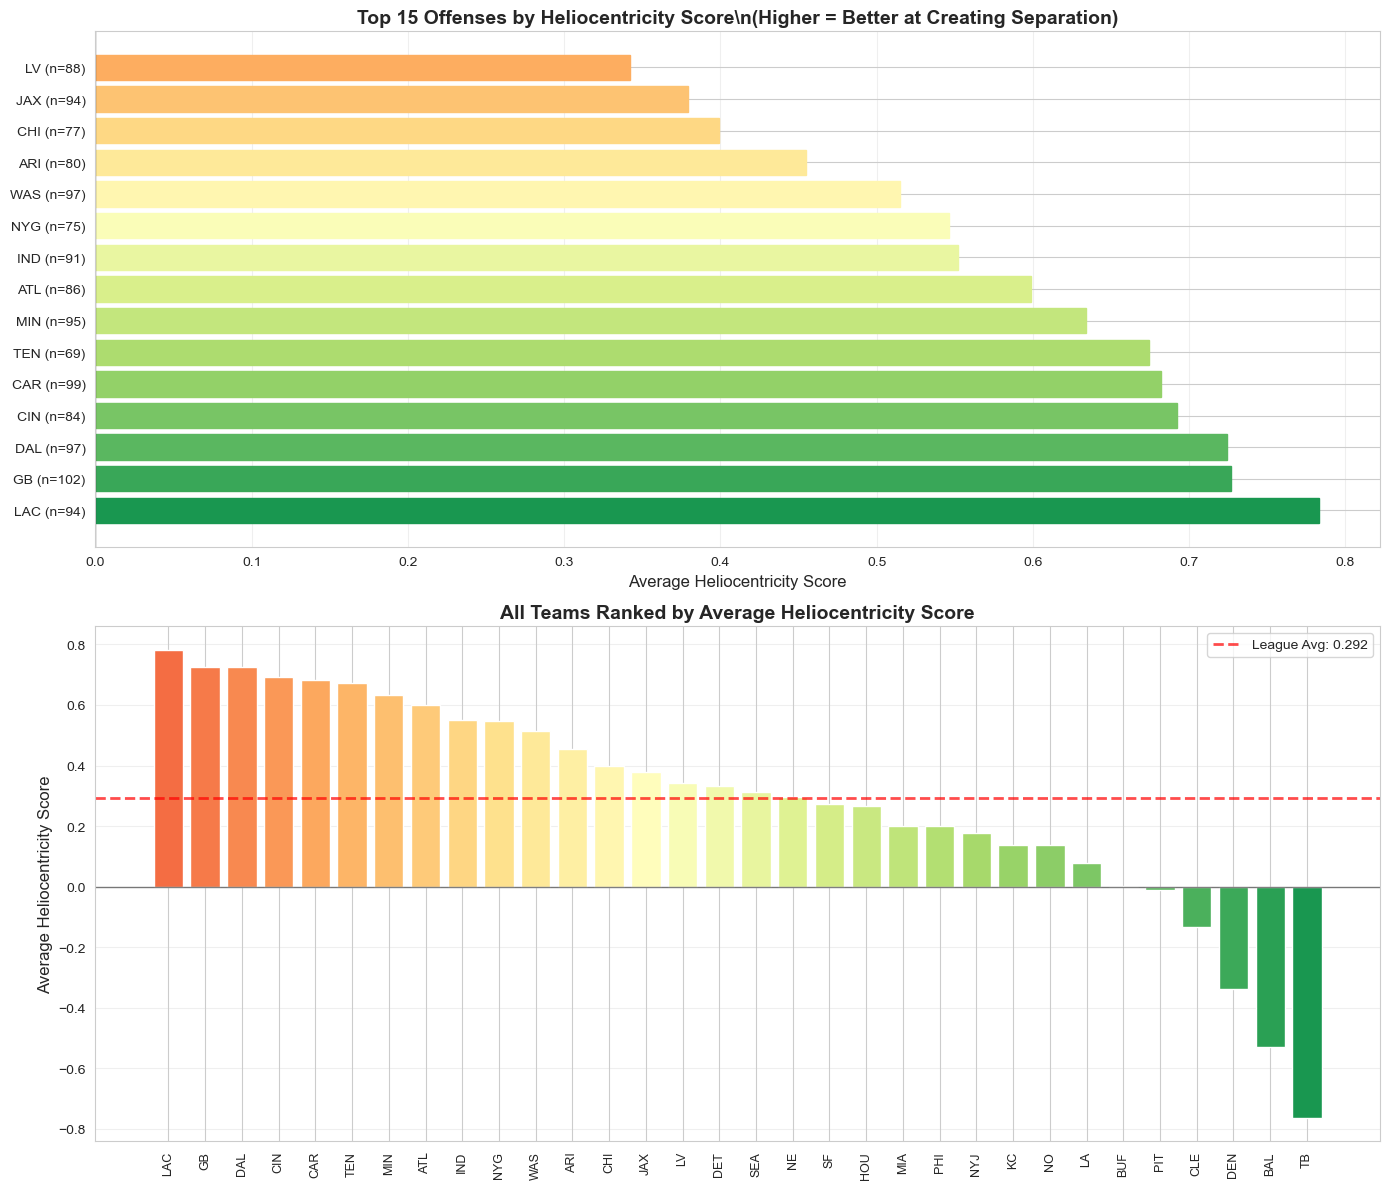

In [69]:
# Visualization: Team offensive performance
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Bar chart: Top 15 teams
top_15_teams = team_stats.nlargest(15, 'avg_H_score')
bars = axes[0].barh(range(len(top_15_teams)), top_15_teams['avg_H_score'].values)
axes[0].set_yticks(range(len(top_15_teams)))
axes[0].set_yticklabels([f"{team} (n={n})" for team, n in zip(top_15_teams['possession_team'], top_15_teams['total_plays'])])
axes[0].set_xlabel('Average Heliocentricity Score', fontsize=12)
axes[0].set_title('Top 15 Offenses by Heliocentricity Score\\n(Higher = Better at Creating Separation)', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].grid(axis='x', alpha=0.3)

# Color bars by value
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

# All teams comparison
team_stats_sorted = team_stats.sort_values('avg_H_score', ascending=False)
bars2 = axes[1].bar(range(len(team_stats_sorted)), team_stats_sorted['avg_H_score'].values, 
                     color=plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(team_stats_sorted))))
axes[1].set_xticks(range(len(team_stats_sorted)))
axes[1].set_xticklabels(team_stats_sorted['possession_team'].values, rotation=90, fontsize=9)
axes[1].set_ylabel('Average Heliocentricity Score', fontsize=12)
axes[1].set_title('All Teams Ranked by Average Heliocentricity Score', fontsize=14, fontweight='bold')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].axhline(team_stats_sorted['avg_H_score'].mean(), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f"League Avg: {team_stats_sorted['avg_H_score'].mean():.3f}")
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [70]:
# Team-Player combinations: Which teams get the most from their receivers?
team_player_stats = helio_with_teams.groupby(['possession_team', 'star_player_id', 'player_name']).agg({
    'H_score': ['mean', 'count']
}).round(3)

team_player_stats.columns = ['avg_H_score', 'play_count']
team_player_stats = team_player_stats.reset_index()

# Filter for meaningful sample size
team_player_qualified = team_player_stats[team_player_stats['play_count'] >= 5]

print("=" * 80)
print("TOP 20 TEAM-PLAYER COMBINATIONS (Min 5 plays)")
print("=" * 80)
top_combos = team_player_qualified.nlargest(20, 'avg_H_score')[['possession_team', 'player_name', 'avg_H_score', 'play_count']]
print(top_combos.to_string(index=False))

# For each top team, show their best receivers
print("\n" + "=" * 80)
print("BEST RECEIVERS FOR TOP 5 OFFENSES")
print("=" * 80)

for team in top_offenses.head(5)['possession_team'].values:
    team_receivers = team_player_qualified[team_player_qualified['possession_team'] == team].nlargest(5, 'avg_H_score')
    print(f"\n{team}:")
    print(team_receivers[['player_name', 'avg_H_score', 'play_count']].to_string(index=False))

TOP 20 TEAM-PLAYER COMBINATIONS (Min 5 plays)
possession_team       player_name  avg_H_score  play_count
             GB    Amik Robertson        3.864           5
            DAL       CeeDee Lamb        3.280           8
            JAX  Shaquill Griffin        2.707           6
            TEN       Chris Moore        2.693           6
            ARI    Marquise Brown        2.580          17
            DAL     Michael Davis        2.364           6
             LV     Jakobi Meyers        2.345           8
            CLE      Jordan Akins        2.274           5
            MIN  Justin Jefferson        2.208           8
            NYG    Darius Slayton        2.200           9
            HOU        Noah Brown        2.167           6
            MIN    Brandon Powell        2.167           5
            ATL    KhaDarel Hodge        2.145          12
            JAX       Jamal Agnew        2.035           5
             LA Demarcus Robinson        2.026           5
          

In [71]:
# Save team-level results
team_output_path = 'dataset/helio/team_offense_heliocentricity.csv'
team_stats.sort_values('avg_H_score', ascending=False).to_csv(team_output_path, index=False)
print(f"✓ Saved team offense statistics to {team_output_path}")

team_player_output = 'dataset/helio/team_player_heliocentricity.csv'
team_player_qualified.sort_values('avg_H_score', ascending=False).to_csv(team_player_output, index=False)
print(f"✓ Saved team-player combinations to {team_player_output}")

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("Teams with HIGH heliocentricity scores:")
print("  → Effective at creating separation through scheme, play design, or talent")
print("  → Defenses gave their receivers MORE space than expected")
print("  → Could indicate good route concepts, misdirection, or elite receiver talent")
print("\nTeams with LOW heliocentricity scores:")
print("  → Struggled to create separation for receivers")
print("  → Defenses played TIGHTER coverage than expected")
print("  → Could indicate predictable schemes or receivers who draw less attention")

✓ Saved team offense statistics to dataset/helio/team_offense_heliocentricity.csv
✓ Saved team-player combinations to dataset/helio/team_player_heliocentricity.csv

INTERPRETATION
Teams with HIGH heliocentricity scores:
  → Effective at creating separation through scheme, play design, or talent
  → Defenses gave their receivers MORE space than expected
  → Could indicate good route concepts, misdirection, or elite receiver talent

Teams with LOW heliocentricity scores:
  → Struggled to create separation for receivers
  → Defenses played TIGHTER coverage than expected
  → Could indicate predictable schemes or receivers who draw less attention
